In [1]:
# Imports 


import sys
# setting path
sys.path.append('../core')
import os
#os.environ["VECLIB_MAXIMUM_THREADS"] = "10"

from sklearn.decomposition import PCA

#bread and butter
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

#machine learning library
import sklearn
import sklearn.manifold
import sklearn.cluster
import sklearn.decomposition

#statistics
import scipy
from scipy.stats import rankdata, norm

import numba
from numba import jit, njit

from tqdm import tqdm
import copy
import cvxpy as cp

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline
#import numpy as tnp
import warnings
warnings.filterwarnings('ignore')

# import dfply
# from dfply import *
# import ray
# import datetime


import os
import warnings
warnings.filterwarnings("ignore")

#import torch
#torch.cuda.is_available()
import tensorflow as tf
print(tf.config.list_physical_devices('GPU'))

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd
import scipy

import confound_mdp
import confound_ope
import confound_env
import copy
import pickle

from subspace import *
from clustering import *
from emalg import *
from helpers import *

%matplotlib inline
plt.style.use('matplotlibrc')

2023-01-25 00:40:39.989529: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-25 00:40:40.045334: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-01-25 00:40:40.317510: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-01-25 00:40:40.317536: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not l

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


2023-01-25 00:40:40.616888: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-25 00:40:40.632400: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-25 00:40:40.632472: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


In [2]:
d_min = np.minimum(getN_sa(dataset[dataset[:,:,2]==0], nStates, nActions, burnin=0, reshape=False)/len(dataset[dataset[:,:,2]==0]),
           getN_sa(dataset[dataset[:,:,2]==1], nStates, nActions, burnin=0, reshape=False)/len(dataset[dataset[:,:,2]==1]))


NameError: name 'dataset' is not defined

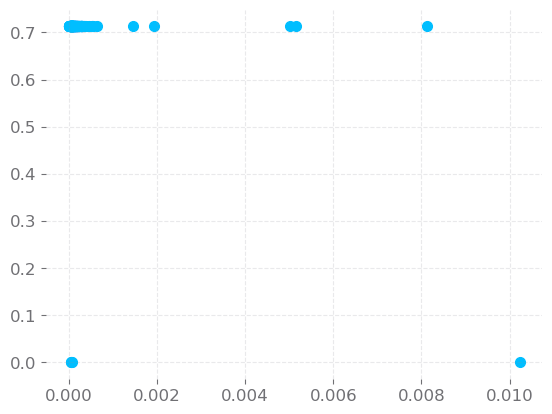

In [34]:
plt.scatter(d_min.flatten(), np.linalg.norm((P[0])-(P[1]), axis=-1).flatten())

In [3]:
diagnostic = False
horizons = [20, 30, 40, 50, 60, 70, 80, 90, 100]#, 120, 140, 160, 180, 200]
horizons = [100]

trials = 30
import multiprocessing


clusterAccsTrials = []
clusterAccsNoProjsTrials = []
classAccsTrials = []
hardClustEMAccsTrials = []
softClustEMAccsTrials = []
hardEMAccsTrials = []
softEMAccsTrials = []

for trial in range(trials):
    clusterAccs = []
    clusterAccsNoProjs = []
    modelEstims = []
    classAccs = []
    hardClustEMs = []
    hardClustEMAccs = []
    softClustEMs = []
    softClustEMAccs = []
    hardEMs = []
    hardEMAccs = []
    softEMs = []
    softEMAccs = []
    
    start_seed = trial*multiprocessing.cpu_count()
    print("Trial", trial, "with start seed", start_seed)

    for horizon in horizons:
        print("Current Horizon is:", horizon)

        ###GRIDWORLD###
    
        pi_b, P, R, x_dist, u_dist, gamma = confound_env.gridworld_opetools(horizon = horizon, slip = 0.04, 
                                                                        confound_weight=0.6, small=False, soft=True)
        pi_b[0] = pi_b.mean(0)
        pi_b[1] = pi_b.mean(0)

        mdp = confound_mdp.ConfoundMDP(P, R, x_dist, u_dist, gamma)

        nStates = P.shape[2]
        nActions = P.shape[1]

        ###GRIDWORLD###

        dataset = getSamplesMultiProc(1000, mdp, pi_b, horizon, start_seed=start_seed, iid=False)

         # behavior value
        print("value of pi_b")
        returns = confound_mdp.calc_returns(dataset, gamma, horizon)
        print(returns.mean())
    

        stateactions = dataset[:, :, [0, 1]]
        memorder = 'C'

        if memorder == 'F':
            stateactions = (dataset[:,:,0] + dataset[:,:,1]*nStates).astype(int) #we code (S x A) as s + a|S|, 0,16,32,48 1,17,33,49
        else:
            stateactions = (dataset[:,:,0]*nActions + dataset[:,:,1]).astype(int)
        states = (dataset[:,:,0]).astype(int)
        actions = (dataset[:,:,1]).astype(int)
        currstates = dataset[:,:,[0,1]].astype(int)
        confounders = dataset[:,:,2].astype(int)
        labels = confounders[:,0].astype(int)
        nextstates = dataset[:,:,3].astype(int)

        L = 2
        K = 2
        #S = nStates*nActions
        #N = len(threes)


        ########SUBSPACE ESTIMATION########

        sadim = nStates*nActions
        spdim = nStates
        omegaone = np.array([i for i in range(int(horizon/4), 2*int(horizon/4))])
        omegatwo = np.array([i for i in range(3*int(horizon/4), horizon)])
        onehotsa = np.eye(sadim)[stateactions]
        #onehotsaflat = copy.deepcopy(onehotsa)
        onehotsa = onehotsa.reshape((onehotsa.shape[0], onehotsa.shape[1], nStates, nActions), order=memorder)
        onehotsp = np.eye(np.max(nextstates)+1)[nextstates]
        sz = int(onehotsa.shape[0]/3)

        eigvalsa, eigvecsa = getEig(onehotsa[:sz], onehotsp[:sz], omegaone, omegatwo, K, wt=True, smalldata=False, device='/GPU:0')

        #########CLUSTERING#########

        device = "/GPU:0"

        hs = np.array([geth(onehotsa[sz:,omegaone,:,:], 
                                         onehotsp[sz:,omegaone,:]), 
                                  geth(onehotsa[sz:,omegatwo,:,:], 
                                       onehotsp[sz:,omegatwo,:])], dtype=np.float32)

        statmns = computeStat(hs, 
                          eigvecsa, numpy=False, smalldata=False, device=device, proj=True)
        if diagnostic:
            clusterDiagnostics(statmns, K=K, labels=confounders[sz:, 0],
                           lo=0, hi=0.0005, step=0.000025) #0,0.01, 0.0001
            plt.show()
            clusterDiagnostics(statNoProjs, K=K, labels=confounders[sz:, 0],
                       lo=0, hi=0.0005, step=0.000025) #0,0.01, 0.0001
            plt.show()

        statNoProjs = computeStat(hs, 
                          eigvecsa, numpy=False, smalldata=False, device=device, proj=False)

        clusterlabs = sklearn.cluster.spectral_clustering((statmns < 0.0001).astype(int), n_clusters=2,
                                                         assign_labels='kmeans')

        clusterlabsNoProjs = sklearn.cluster.spectral_clustering((statNoProjs < 0.0001).astype(int), n_clusters=2,
                                                         assign_labels='kmeans')
    
        
        
        
        permutation = np.argmax([np.mean(clusterlabs == confounders[sz:, 0]), 
                        np.mean(clusterlabs != confounders[sz:, 0])])
        if diagnostic:
            print(permutation, np.max([np.mean(clusterlabs == confounders[sz:, 0]), 
                        np.mean(clusterlabs != confounders[sz:, 0])]))
        clusterAccs.append(np.max([np.mean(clusterlabs == confounders[sz:, 0]), 
                        np.mean(clusterlabs != confounders[sz:, 0])]))

        clusterAccsNoProjs.append(np.max([np.mean(clusterlabsNoProjs == confounders[sz:, 0]), 
                        np.mean(clusterlabsNoProjs != confounders[sz:, 0])]))

        ########MODEL ESTIMATION#########
        Phat_ksa = getModelEstim(clusterlabs.astype(int), 
                             states[sz:,:], 
                             actions[sz:,:], 
                             nextstates[sz:,:],
                            K=K, nStates=nStates, nActions=nActions, hard=True)
        modelEstims.append(Phat_ksa)


        ########CLASSIFICATION#########
        priorclass = np.bincount(clusterlabs)/len(clusterlabs) 
        piclust = getPolicyEstim(states[sz:], actions[sz:], 
                                 K, nStates, nActions, preds=clusterlabs, hard=True)
        startweights = getStartWeights(states[sz:], clusterlabs, K, nStates)
        subspaceClass = classify(Phat_ksa, states[:sz,:], actions[:sz,:], 
                               nextstates[:sz,:], piclust, reg=1, 
                           prior=priorclass, startweights = startweights, labs=True)
        if diagnostic:
            print('Subspace Classification accuracy:', [np.mean(labels[:sz] == subspaceClass), 
                                                    np.mean(labels[:sz] != subspaceClass)][permutation])
        classAccs.append([np.mean(labels[:sz] == subspaceClass), np.mean(labels[:sz] != subspaceClass)][permutation])


        ########EM ALGORITHM########
        priorclass = np.bincount(clusterlabs)/len(clusterlabs) 
        piclust = getPolicyEstim(states[sz:], actions[sz:], 
                                 K, nStates, nActions, preds=clusterlabs, hard=True)

        startweights = getStartWeights(states[sz:], clusterlabs, K, nStates)
        maxapos = classify(Phat_ksa, states, actions, 
                               nextstates, piclust, reg=1, 
                           prior=priorclass, startweights = startweights, labs=True)
        mleprobs = classify(Phat_ksa, states, actions, 
                               nextstates, piclust, reg=1, 
                            prior=priorclass, startweights = startweights, labs=False)
        if diagnostic:
            print('MAP estimate overall accuracy:', [np.mean(labels == maxapos), np.mean(labels != maxapos)][permutation])

        # HARD EM
        expectclass, modelestimclass, loglikclass = em(maxapos, 
                                Phat_ksa, states, actions, 
                            nextstates, labels=labels, 
                            K=K, nStates=nStates, nActions=nActions,
                            prior = priorclass, reg = 1, max_iter=100,
                                                   permute=False, permutation=permutation,
                                                   checkin=1, hard=True, verbose=False)
        hardClustEMs.append([expectclass, modelestimclass, loglikclass])
        hardClustEMAccs.append(np.max([np.mean(labels == expectclass), np.mean(labels != expectclass)]))

        # SOFT EM
        normprobs = np.exp(mleprobs-np.max(mleprobs))
        regprobs = 0.8*(normprobs)/np.nansum(np.abs(normprobs), 0) + 0.1*np.ones(mleprobs.shape)
        expectclasssoft, modelestimclasssoft, loglikclasssoft = em(regprobs, 
                                    Phat_ksa, states, actions, 
                                nextstates, labels, 
                                K=2, nStates=nStates, nActions=nActions,
                                prior = priorclass, reg = 1, permute=False,
                                permutation=permutation, checkin=1, hard=False, verbose=False)
        softClustEMs.append([expectclasssoft, modelestimclasssoft, loglikclasssoft])
        softClustEMAccs.append(np.max([np.mean(labels == expectclasssoft.argmax(0)),
                                np.mean(labels != expectclasssoft.argmax(0))]))

        #############BASE EM###############

        labelsem = []
        logliksem = []
        for i in tqdm(range(30)):
            randlabs = np.random.binomial(1, 0.5, size=len(dataset)).astype(int)
            randmodel = getModelEstim(randlabs, states, actions, nextstates,
                                      K, nStates, nActions, hard=True)
            randlabs, randmodel, loglikrand = em(randlabs, randmodel,
               states, actions, nextstates, labels, 
                                K=K, nStates=nStates, nActions=nActions,
                                prior = priorclass, reg = 0, permute=True, permutation=permutation, checkin=1, verbose=False, hard=True)
            labelsem.append(randlabs)
            logliksem.append(loglikrand)
        if diagnostic:
            plt.figure(figsize=(12,7))
            plt.scatter([max(np.mean(i == labels), np.mean(i != labels)) for i in labelsem], logliksem)
            print(np.mean([max(np.mean(i == labels), np.mean(i != labels)) for i in labelsem]))
            print(np.median([max(np.mean(i == labels), np.mean(i != labels)) for i in labelsem]))
            print(np.max([max(np.mean(i == labels), np.mean(i != labels)) for i in labelsem]))
            plt.xlabel('Accuracy')
            plt.ylabel('Log-likelihood')
            plt.title('Randomly Initialized Hard EM Algorithm')
            plt.show()
            plt.hist([max(np.mean(i == labels), np.mean(i != labels)) for i in labelsem])
            plt.show()
        hardEMAccs.append(np.mean([max(np.mean(i == labels), np.mean(i != labels)) for i in labelsem]))
        hardEMs.append([labelsem, logliksem])

        labelsemsoft = []
        logliksemsoft = []
        for i in tqdm(range(30)):
            unifs = np.random.uniform(size=len(dataset))
            randlabsoft = np.vstack([unifs, 1-unifs])
            randmodelsoft = getModelEstim(randlabsoft, states, actions, nextstates,
                                      K, nStates, nActions, hard=False)
            randlabsoft, randmodelsoft, loglikrand = em(randlabsoft, randmodelsoft,
           states, actions, nextstates, labels, 
                                K=K, nStates=nStates, nActions=nActions,
                                prior = priorclass, reg = 0, permute=True, permutation=permutation, checkin=1, verbose=False, hard=False)
            labelsemsoft.append(randlabsoft)
            logliksemsoft.append(loglikrand)
        if diagnostic:
            plt.figure(figsize=(12,7))
            plt.scatter([max(np.mean(i == labels), np.mean(i != labels)) for i in np.array(labelsemsoft).argmax(axis=1)], 
                        logliksemsoft)
            print(np.mean([max(np.mean(i == labels), np.mean(i != labels)) for i in np.array(labelsemsoft).argmax(axis=1)]))
            print(np.median([max(np.mean(i == labels), np.mean(i != labels)) for i in np.array(labelsemsoft).argmax(axis=1)]))
            print(np.max([max(np.mean(i == labels), np.mean(i != labels)) for i in np.array(labelsemsoft).argmax(axis=1)]))
            plt.ticklabel_format(style='plain',useOffset=False)
            plt.xlabel('Accuracy')
            plt.ylabel('Log-likelihood')
            plt.title('Randomly Initialized Soft EM Algorithm')
            plt.show()
            plt.hist([max(np.mean(i == labels), np.mean(i != labels)) for i in np.array(labelsemsoft).argmax(axis=1)])
            plt.show()
        softEMAccs.append(np.mean([max(np.mean(i == labels), np.mean(i != labels)) for i in np.array(labelsemsoft).argmax(axis=1)]))
        softEMs.append([labelsemsoft, logliksemsoft])
        
    clusterAccsTrials.append(clusterAccs)
    clusterAccsNoProjsTrials.append(clusterAccsNoProjs)
    classAccsTrials.append(classAccs)
    hardClustEMAccsTrials.append(hardClustEMAccs)
    softClustEMAccsTrials.append(softClustEMAccs)
    hardEMAccsTrials.append(hardEMAccs)
    softEMAccsTrials.append(softEMAccs)

Trial 0 with start seed 0
Current Horizon is: 100
value of pi_b
-3.476886461647142


2023-01-25 00:41:13.266184: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-25 00:41:13.267146: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-25 00:41:13.267244: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-25 00:41:13.267288: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at

Trial 1 with start seed 32
Current Horizon is: 100
value of pi_b
-3.0131450004137355


100%|██████████| 30/30 [00:14<00:00,  2.01it/s]


Trial 2 with start seed 64
Current Horizon is: 100
value of pi_b
-3.5052455992512255


100%|██████████| 30/30 [00:14<00:00,  2.05it/s]


Trial 3 with start seed 96
Current Horizon is: 100
value of pi_b
-3.330378018198976


100%|██████████| 30/30 [00:14<00:00,  2.04it/s]


Trial 4 with start seed 128
Current Horizon is: 100
value of pi_b
-3.286659755707716


100%|██████████| 30/30 [00:14<00:00,  2.00it/s]


Trial 5 with start seed 160
Current Horizon is: 100
value of pi_b
-3.2457564444815072


100%|██████████| 30/30 [00:14<00:00,  2.02it/s]


Trial 6 with start seed 192
Current Horizon is: 100
value of pi_b
-3.2581470741157545


100%|██████████| 30/30 [00:14<00:00,  2.06it/s]


Trial 7 with start seed 224
Current Horizon is: 100
value of pi_b
-3.4743746102171147


100%|██████████| 30/30 [00:14<00:00,  2.03it/s]


Trial 8 with start seed 256
Current Horizon is: 100
value of pi_b
-3.301256831396695


100%|██████████| 30/30 [00:14<00:00,  2.02it/s]


Trial 9 with start seed 288
Current Horizon is: 100
value of pi_b
-3.4813614445555374


100%|██████████| 30/30 [00:14<00:00,  2.05it/s]


Trial 10 with start seed 320
Current Horizon is: 100
value of pi_b
-3.262396875144004


100%|██████████| 30/30 [00:14<00:00,  2.07it/s]


Trial 11 with start seed 352
Current Horizon is: 100
value of pi_b
-3.2801174043017753


100%|██████████| 30/30 [00:14<00:00,  2.01it/s]


Trial 12 with start seed 384
Current Horizon is: 100
value of pi_b
-3.5162858016075655


100%|██████████| 30/30 [00:14<00:00,  2.01it/s]


Trial 13 with start seed 416
Current Horizon is: 100
value of pi_b
-3.352977287194819


100%|██████████| 30/30 [00:14<00:00,  2.01it/s]


Trial 14 with start seed 448
Current Horizon is: 100
value of pi_b
-3.4626883626493505


100%|██████████| 30/30 [00:14<00:00,  2.03it/s]


Trial 15 with start seed 480
Current Horizon is: 100
value of pi_b
-3.4104353763540174


100%|██████████| 30/30 [00:14<00:00,  2.08it/s]


Trial 16 with start seed 512
Current Horizon is: 100
value of pi_b
-3.383241490823763


100%|██████████| 30/30 [00:14<00:00,  2.03it/s]


Trial 17 with start seed 544
Current Horizon is: 100
value of pi_b
-3.375269019872474


100%|██████████| 30/30 [00:14<00:00,  2.03it/s]


Trial 18 with start seed 576
Current Horizon is: 100
value of pi_b
-3.2274841545287365


100%|██████████| 30/30 [00:14<00:00,  2.03it/s]


Trial 19 with start seed 608
Current Horizon is: 100
value of pi_b
-3.2108158042592128


100%|██████████| 30/30 [00:14<00:00,  2.04it/s]


Trial 20 with start seed 640
Current Horizon is: 100
value of pi_b
-3.2582649765002567


100%|██████████| 30/30 [00:14<00:00,  2.02it/s]


Trial 21 with start seed 672
Current Horizon is: 100
value of pi_b
-3.355236502936679


100%|██████████| 30/30 [00:14<00:00,  2.01it/s]


Trial 22 with start seed 704
Current Horizon is: 100
value of pi_b
-3.584634270454232


100%|██████████| 30/30 [00:14<00:00,  2.00it/s]


Trial 23 with start seed 736
Current Horizon is: 100
value of pi_b
-3.356948092911949


100%|██████████| 30/30 [00:14<00:00,  2.02it/s]


Trial 24 with start seed 768
Current Horizon is: 100
value of pi_b
-3.146945709678121


100%|██████████| 30/30 [00:14<00:00,  2.03it/s]


Trial 25 with start seed 800
Current Horizon is: 100
value of pi_b
-3.2083062595756453


100%|██████████| 30/30 [00:14<00:00,  2.01it/s]


Trial 26 with start seed 832
Current Horizon is: 100
value of pi_b
-3.219682009934233


100%|██████████| 30/30 [00:14<00:00,  2.05it/s]


Trial 27 with start seed 864
Current Horizon is: 100
value of pi_b
-3.3383578770225326


100%|██████████| 30/30 [00:14<00:00,  2.04it/s]


Trial 28 with start seed 896
Current Horizon is: 100
value of pi_b
-3.274898105804837


100%|██████████| 30/30 [00:14<00:00,  2.02it/s]


Trial 29 with start seed 928
Current Horizon is: 100
value of pi_b
-3.4618805734492653


100%|██████████| 30/30 [00:14<00:00,  2.00it/s]


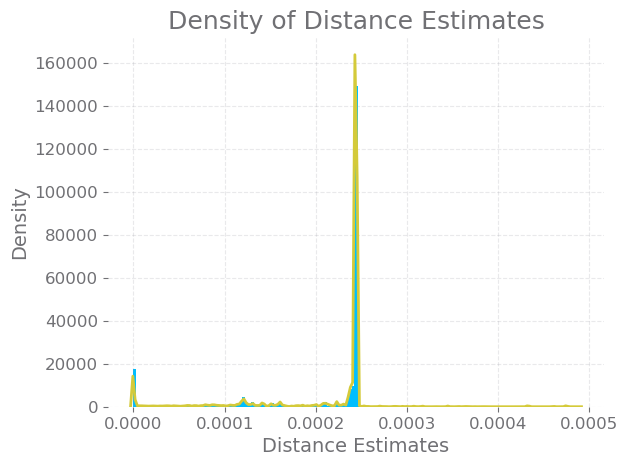

In [4]:
import seaborn as sns
#plt.figure(figsize=(16,9))
plt.hist(statmns.flatten(), bins=200, density=True)#[1]
#plt.hist(statmns.flatten(), bins=onehotsaclust.shape[0], density=True)[2]
sns.kdeplot(statmns.flatten(), bw_adjust=0.2)
#plt.title('')
plt.xlabel('Distance Estimates')
plt.title('Density of Distance Estimates')
plt.savefig('figs/distDens.png')
plt.show()

100%|██████████| 20/20 [00:01<00:00, 16.35it/s]


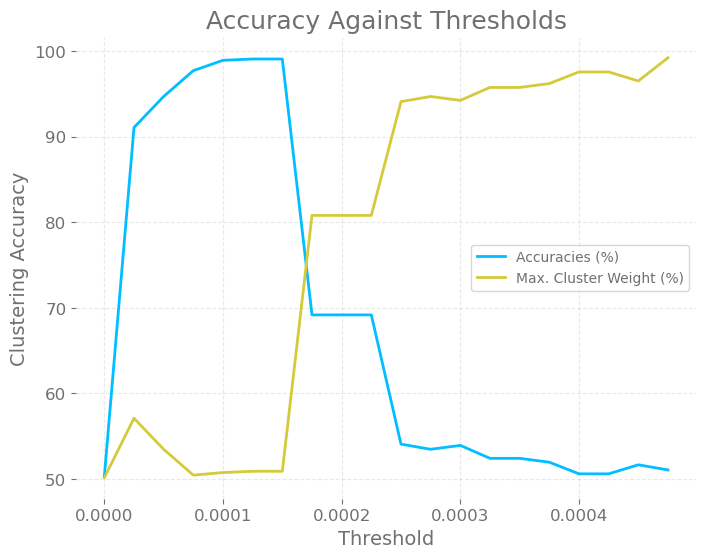

In [78]:
clusterDiagnostics(statmns, K=K, labels=confounders[sz:, 0],
                           lo=0, hi=0.0005, step=0.000025, figsize=(8,6))
plt.ylabel('Clustering Accuracy')
plt.title('Accuracy Against Thresholds')
plt.savefig('figs/clustAccs.png')

0.7569556451612903
0.7741935483870968
0.8800403225806451


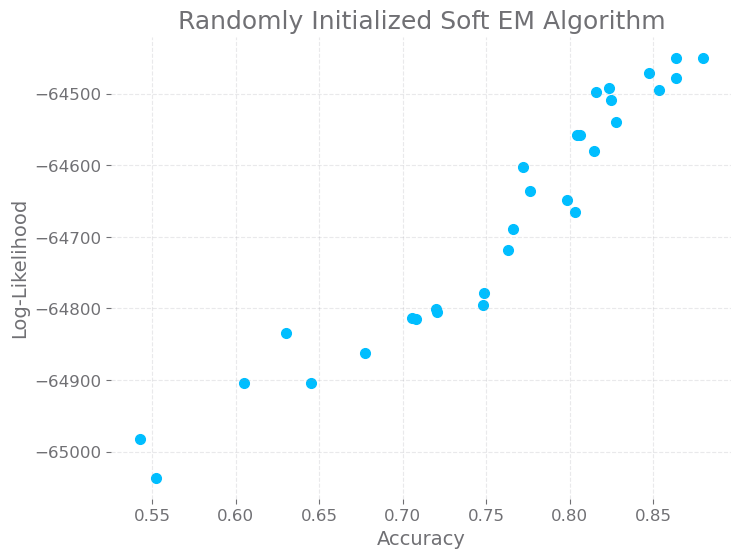

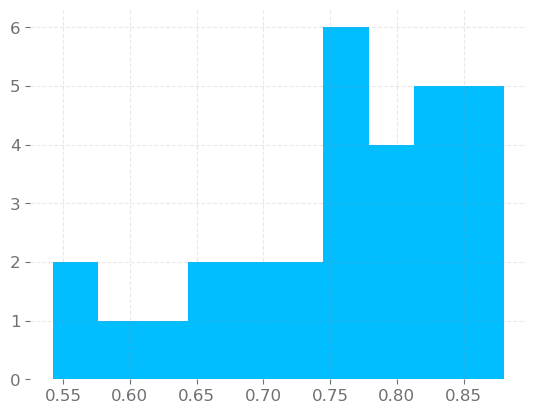

In [5]:
plt.figure(figsize=(8,6))
plt.scatter([max(np.mean(i == labels), np.mean(i != labels)) for i in np.array(labelsemsoft).argmax(axis=1)], 
            logliksemsoft)
print(np.mean([max(np.mean(i == labels), np.mean(i != labels)) for i in np.array(labelsemsoft).argmax(axis=1)]))
print(np.median([max(np.mean(i == labels), np.mean(i != labels)) for i in np.array(labelsemsoft).argmax(axis=1)]))
print(np.max([max(np.mean(i == labels), np.mean(i != labels)) for i in np.array(labelsemsoft).argmax(axis=1)]))
plt.ticklabel_format(style='plain',useOffset=False)
plt.xlabel('Accuracy')
plt.ylabel('Log-Likelihood')
plt.title('Randomly Initialized Soft EM Algorithm')
plt.savefig('figs/softEM.png')
plt.show()
plt.hist([max(np.mean(i == labels), np.mean(i != labels)) for i in np.array(labelsemsoft).argmax(axis=1)])
plt.show()

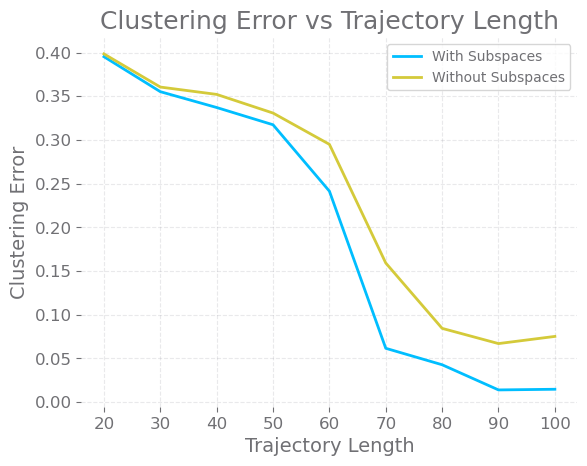

In [77]:
#plt.figure(figsize=(16,9))
plt.plot(horizons, 1-np.mean(np.array(clusterAccsTrials),0), label='With Subspaces')
plt.plot(horizons, 1-np.mean(np.array(clusterAccsNoProjsTrials),0), label='Without Subspaces')
plt.ylabel("Clustering Error")
plt.xlabel("Trajectory Length")
plt.title("Clustering Error vs Trajectory Length")
plt.legend()
plt.savefig('figs/clust.png')

Text(0.5, 1.0, 'Hard EM First Step Error vs Trajectory Length')

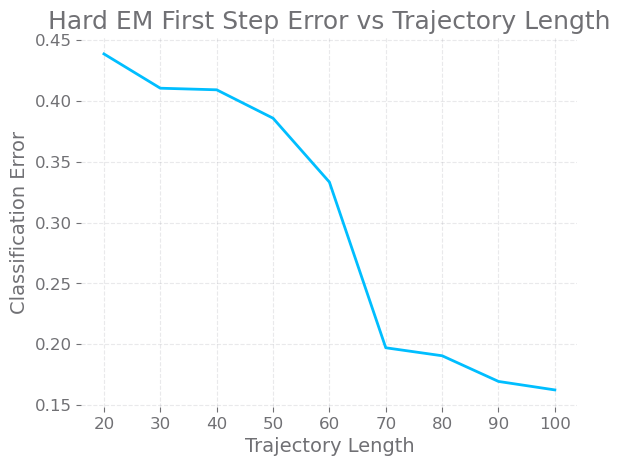

In [88]:
#plt.figure(figsize=(16,9))
plt.plot(horizons, 1-np.mean(np.array(classAccsTrials),0))
plt.ylabel("Classification Error")
plt.xlabel("Trajectory Length")
plt.title("Hard EM First Step Error vs Trajectory Length")
#plt.legend()

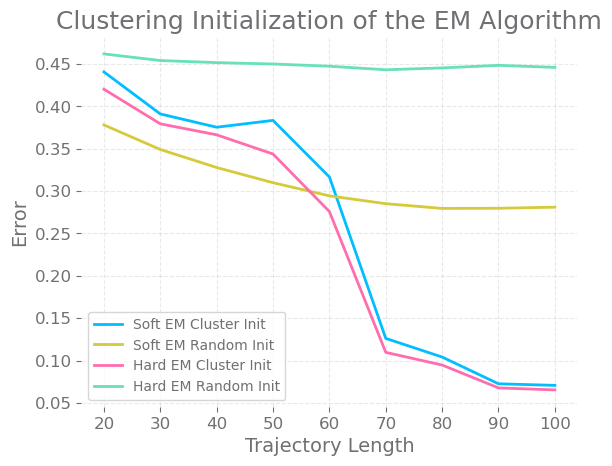

In [87]:
#plt.figure(figsize=(16,9))
'''
plt.plot(horizons, 1-np.median(np.array(hardClustEMAccsTrials),0),
         label='Hard EM Cluster Init')
plt.plot(horizons, 1-np.median(np.array(hardEMAccsTrials),0),
        label='Hard EM')
'''  
plt.plot(horizons, 1-np.mean(np.array(softClustEMAccsTrials),0),
         label='Soft EM Cluster Init')
plt.plot(horizons, 1-np.mean(np.array(softEMAccsTrials),0),
        label='Soft EM Random Init')
plt.plot(horizons, 1-np.mean(np.array(hardClustEMAccsTrials),0),
         label='Hard EM Cluster Init')
plt.plot(horizons, 1-np.mean(np.array(hardEMAccsTrials),0),
        label='Hard EM Random Init')
plt.ylabel("Error")
plt.xlabel("Trajectory Length")
plt.title("Clustering Initialization of the EM Algorithm")
plt.legend()
plt.savefig('figs/emClust.png')

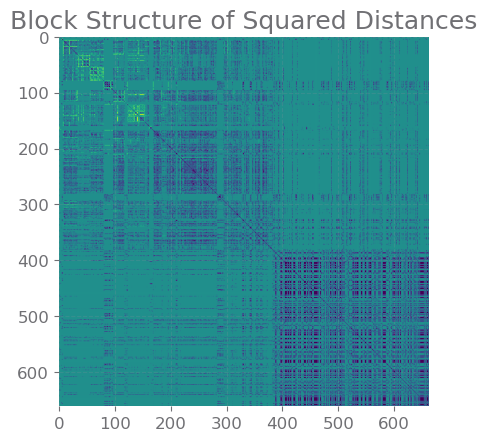

In [10]:
from scipy.cluster.hierarchy import linkage

m = 1-statmns #need similarity matrix
# shuffle
perm = np.random.permutation(len(m))
m = m[perm][:, perm]

# reorder
y = m[np.triu_indices(len(m), k=1)]
Z = linkage(y, method='single', optimal_ordering=True)
perm = np.ravel(Z[:, :2]).astype(np.int32)
perm = perm[perm < len(m)]
m = m[perm][:, perm]

#plt.figure(figsize=(16,9))
plt.imshow(1-m)
plt.title('Block Structure of Squared Distances')
plt.savefig('figs/blocks.png')